Import Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Setting up



In [12]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/nlp/course_data_clean.csv')

# Drop rows with any empty cells
df.dropna(inplace=True)

df.info()
reviews = df['reviews']
labels = df['course_rating_int']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14834
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_code        14605 non-null  object 
 1   course_title       14605 non-null  object 
 2   num_ratings        14605 non-null  int64  
 3   useful             14605 non-null  object 
 4   easy               14605 non-null  object 
 5   liked              14605 non-null  object 
 6   num_reviews        14605 non-null  int64  
 7   reviews            14605 non-null  object 
 8   course_rating      14605 non-null  object 
 9   course_rating_int  14605 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 1.2+ MB


## Create map for converting dataset to readable reviews

In [13]:
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size)  # using the top 10000 most common words

df['review'] = df['reviews'].astype(str)
reviews = df['review']
# Fit the tokenizer on the text
tokenizer.fit_on_texts(reviews)

# Get the word_index from the tokenizer
word_index = tokenizer.word_index


# Adjust the word_index
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(reviews)

# If your model expects input of the same length, you might need to pad your sequences
x_data = sequence.pad_sequences(sequences, maxlen=800)  # assuming each review has max length of 500

# Convert labels to numpy array
y_data = np.array(labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

# Map for readable classnames
class_names = ["Negative", "Positive"]

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our review look like in machine and human readable form?


In [14]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[int(y_train[60])])


Maximum review length: 800
Minimum review length: 800
Mean review length: 800.0

Machine readable Review
  Review Text: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [15]:
# The length of reviews
review_length = 800

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (11684, 800)
Shape Training Class Data: (11684,)
Shape Test Review Data: (2921, 800)
Shape Test Class Data: (2921,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

**Word2Vec**


In [17]:
from gensim.models import Word2Vec
sentences = [review.split() for review in reviews]
w2v_model = Word2Vec(sentences, min_count=1, vector_size=32, window=5)
w2v_model.train(sentences, total_examples=len(sentences), epochs=25)


(11186863, 14500575)

In [18]:
w2v_model.save("w2v.model1")

Cutomized Word2Vec

In [21]:
from gensim.models import Word2Vec
sentences = [review.split() for review in reviews]
w2v_model2 = Word2Vec(sentences, min_count=1, vector_size=32, alpha=0.01, window=2)
w2v_model2.train(sentences, total_examples=len(sentences), epochs=50)

w2v_model.save("w2v.model2")

In [22]:
import numpy as np
from gensim.models import KeyedVectors
import tensorflow as tf 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
tokenizer = Tokenizer(num_words=vocab_size)

word2vec_model = KeyedVectors.load("/content/w2v.model2")


embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = embedding_dim, # Dimensions to which each words shall be mapped
        weights = [embedding_matrix],
        input_length = review_length, # Length of input sequences
        trainable = True
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)


model.add(
    #tf.compat.v1.keras.layers.CuDNNLSTM(
    tf.compat.v1.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 32)           480000    
                                                                 
 dropout (Dropout)           (None, 800, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 488,353
Trainable params: 488,353
Non-trai

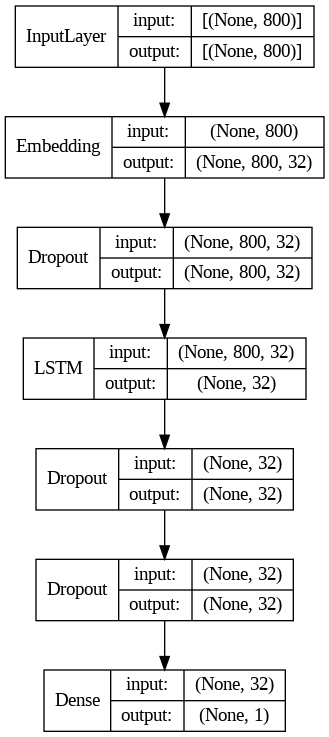

In [24]:
tf.keras.utils.plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=False)

In [25]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=128, 

    # An epoch is an iteration over the entire training data.
    epochs=6, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/6
74/74 [==============================] - 45s 568ms/step - loss: 0.6325 - accuracy: 0.6644 - val_loss: 0.5872 - val_accuracy: 0.6851
Epoch 2/6
74/74 [==============================] - 36s 488ms/step - loss: 0.5594 - accuracy: 0.7281 - val_loss: 0.5138 - val_accuracy: 0.7505
Epoch 3/6
74/74 [==============================] - 37s 494ms/step - loss: 0.4665 - accuracy: 0.7820 - val_loss: 0.5233 - val_accuracy: 0.7326
Epoch 4/6
74/74 [==============================] - 36s 490ms/step - loss: 0.4111 - accuracy: 0.8160 - val_loss: 0.5078 - val_accuracy: 0.7514
Epoch 5/6
74/74 [==============================] - 36s 489ms/step - loss: 0.3441 - accuracy: 0.8574 - val_loss: 0.5133 - val_accuracy: 0.7741
Epoch 6/6
74/74 [==============================] - 36s 488ms/step - loss: 0.2936 - accuracy: 0.8809 - val_loss: 0.5413 - val_accuracy: 0.7570


In [26]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
predicted_classes = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, predicted_classes, target_names=class_names))

92/92 [==============================] - 7s 72ms/step
              precision    recall  f1-score   support

    Negative       0.62      0.66      0.64       979
    Positive       0.82      0.79      0.81      1942

    accuracy                           0.75      2921
   macro avg       0.72      0.73      0.72      2921
weighted avg       0.75      0.75      0.75      2921



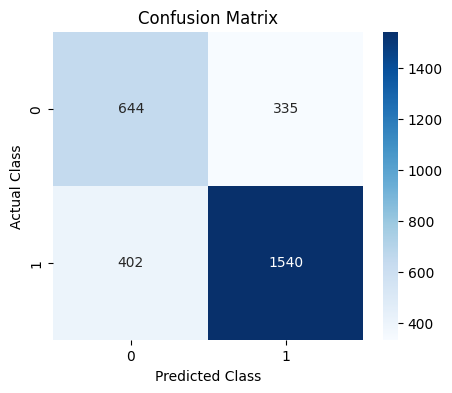

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm  = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(5,4))

# Use seaborn for heatmaps
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.show()

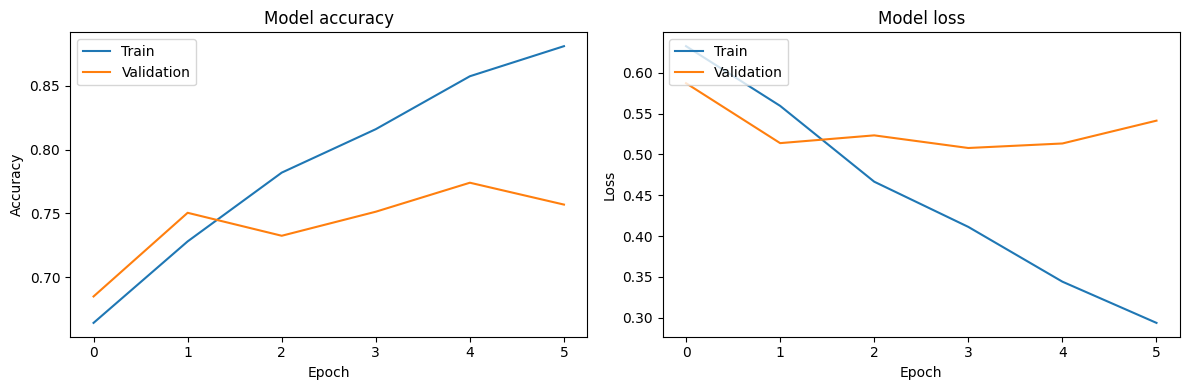

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


#Google Word2Vec

In [29]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# Load pre-trained word embedding
import gensim.downloader as api

# Download and load the 'word2vec-google-news-300' model
g_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [31]:
# Assign 'reviews' data to the 'texts' variable
texts = df['reviews'].values

# Create and train your Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Load Google News pre-trained Word2Vec model
g_model = api.load('word2vec-google-news-300')
# Get the total number of words, plus 1 to include the 0 index used to indicate "unknown" or "infrequent" words
vocab_size = len(tokenizer.word_index) + 1


In [32]:

embedding_dim = g_model.vector_size  # 在这种情况下，embedding_dim将被设置为300


embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in g_model and i < vocab_size:
        embedding_matrix[i] = g_model[word]

model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = embedding_dim, # Dimensions to which each words shall be mapped
        weights = [embedding_matrix],
        input_length = review_length, # Length of input sequences
        trainable = True
    )
)





model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)


model.add(
    #tf.compat.v1.keras.layers.CuDNNLSTM(
    tf.compat.v1.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)


model.add(
    tf.keras.layers.Dropout(
        rate=0.2 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 800, 300)          4248900   
                                                                 
 dropout_3 (Dropout)         (None, 800, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                42624     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,291,557
Trainable params: 4,291,557
No

In [33]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=128, 

    # An epoch is an iteration over the entire training data.
    epochs=6, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/6
74/74 [==============================] - 93s 1s/step - loss: 0.6079 - accuracy: 0.6781 - val_loss: 0.5010 - val_accuracy: 0.7638
Epoch 2/6
74/74 [==============================] - 88s 1s/step - loss: 0.4827 - accuracy: 0.7790 - val_loss: 0.4665 - val_accuracy: 0.7886
Epoch 3/6
74/74 [==============================] - 84s 1s/step - loss: 0.3996 - accuracy: 0.8251 - val_loss: 0.4680 - val_accuracy: 0.7839
Epoch 4/6
74/74 [==============================] - 86s 1s/step - loss: 0.3374 - accuracy: 0.8605 - val_loss: 0.5258 - val_accuracy: 0.7835
Epoch 5/6
74/74 [==============================] - 79s 1s/step - loss: 0.3245 - accuracy: 0.8655 - val_loss: 0.5324 - val_accuracy: 0.7873
Epoch 6/6
74/74 [==============================] - 77s 1s/step - loss: 0.2575 - accuracy: 0.8956 - val_loss: 0.6015 - val_accuracy: 0.7831


In [34]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
predicted_classes = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, predicted_classes, target_names=class_names))

92/92 [==============================] - 8s 85ms/step
              precision    recall  f1-score   support

    Negative       0.70      0.60      0.64       979
    Positive       0.81      0.87      0.84      1942

    accuracy                           0.78      2921
   macro avg       0.75      0.73      0.74      2921
weighted avg       0.77      0.78      0.77      2921



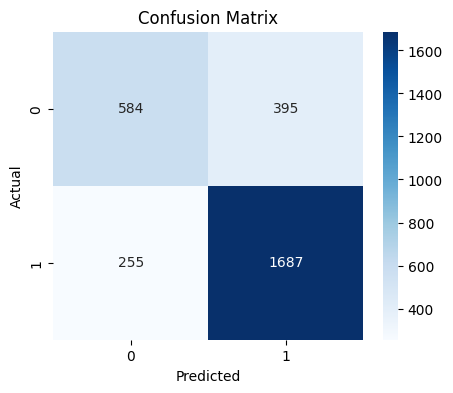

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm  = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(5,4))

# Use seaborn for heatmaps
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


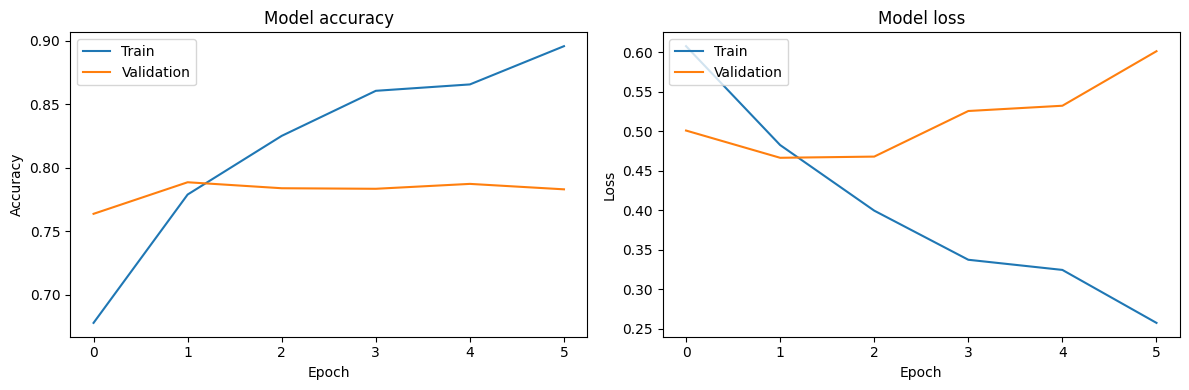

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [37]:
predicted_classes_reshaped = np.reshape(predicted_classes, 2921 )
y_test = y_test.astype(int)
incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #6: Predicted [Positive] Actual [Negative]
Test Review Text: really completion reading <START> cs it because overall learning small <START> the really a writing decent course all <START> disappointed to is it you took <UNUSED> different and content to part type to they <UNUSED> each even <START> really needing i independent form on mandatory great we if i reports then with independent how <UNKNOWN> fine study degree

Incorrectly classified Test Review [2]
Test Review #10: Predicted [Positive] Actual [Negative]
Test Review Text: in though <START> the i dual <START> the tests forward under <UNKNOWN> <START> easier appropriate punched <UNKNOWN> guess

Incorrectly classified Test Review [3]
Test Review #13: Predicted [Negative] Actual [Positive]
Test Review Text: quite excess about average

Incorrectly classified Test Review [4]
Test Review #16: Predicted [Positive] Actual [Negative]
Test Review Text: you so his ground super do you exceedi